- https://avisingh599.github.io/vision/visual-odometry-full/

$$
s \cdot (u,v,1) = K [R, t] [X,Y,Z,1]
$$

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys
sys.path.append('..')

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import cv2
from opencv_camera import bgr2gray, gray2bgr
from helpers import SaveVideo
from tqdm.notebook import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
from ipywidgets import Video

import pickle
from collections import deque, namedtuple
from slurm.files import rm

In [13]:
with open("../../videos/flow-stereo.pkl", "rb") as fd:
    frames = pickle.load(fd)
    
print(f">> Loaded {len(frames)} images")

>> Loaded 167 images


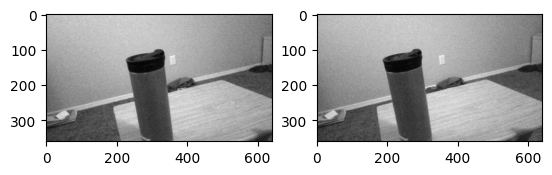

In [14]:
leftimgs = []
rightimgs = []

r,c = frames[0].shape[:2]

f = max(r,c)  # focal length is a function of image size in pixels
K = np.array([
    [f,0,c//2],
    [0,f,r//2],
    [0,0,1]
])

for im in frames:
    im = cv2.rotate(im, cv2.ROTATE_180)
    leftimgs.append(im[:,:c//2])
    rightimgs.append(im[:,c//2:])
    
plt.subplot(121); plt.imshow(leftimgs[0], cmap="gray"); 
plt.subplot(122); plt.imshow(rightimgs[0], cmap="gray");

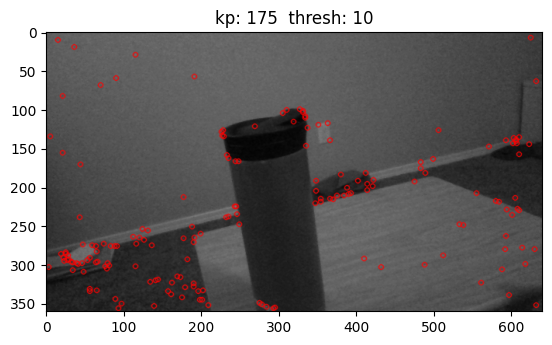

In [15]:
thresh = dict(threshold=10, nonmaxSuppression=True)
fast = cv2.FastFeatureDetector_create(**thresh)

im = leftimgs[0]
im = gray2bgr(im)

flags = 0 #cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
kp = fast.detect(im)
im = cv2.drawKeypoints(im,kp,None,(255,0,0),flags)
plt.imshow(im)
plt.title(f"kp: {len(kp)}  thresh: {thresh['threshold']}");

19.0


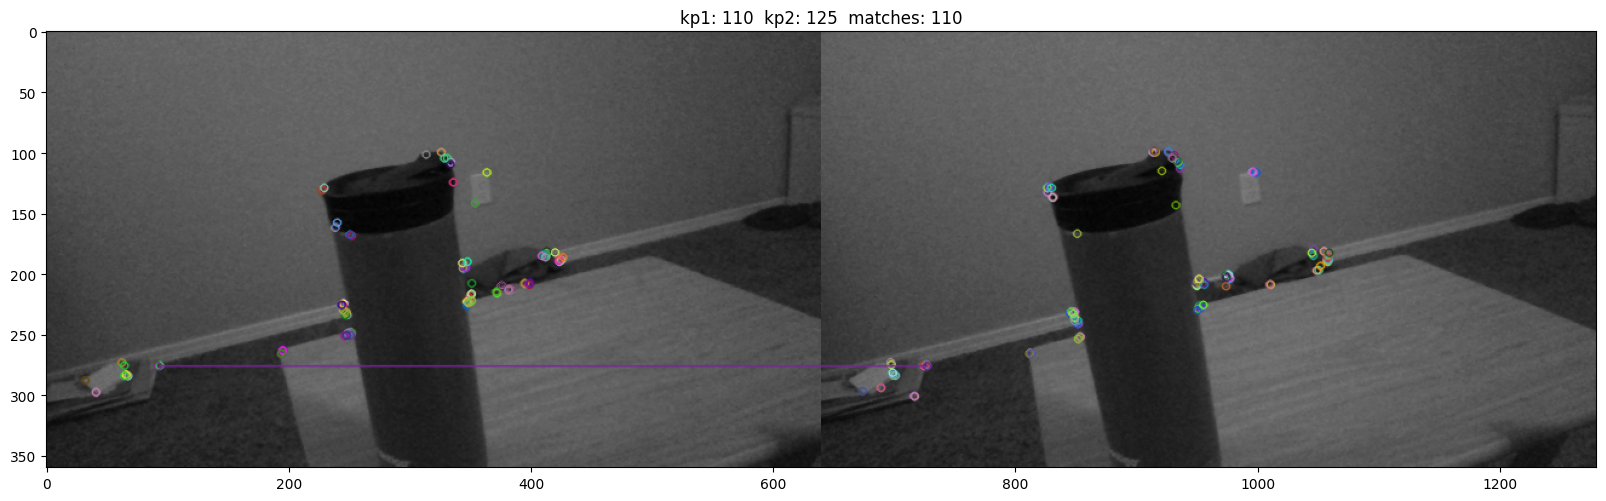

In [16]:
def draw(left, right):
    # thresh = dict(threshold=10, nonmaxSuppression=True)
    # fast = cv2.FastFeatureDetector_create(**thresh)
    # Detect ORB features and compute descriptors.
    MAX_FEATURES = 1000
    GOOD_MATCH_PERCENT = 1.0
    orb = cv2.ORB_create(MAX_FEATURES)
    
    left = gray2bgr(left)
    right = gray2bgr(right)

    # kp1 = fast.detect(left)
    # kp2 = fast.detect(right)
    kp1, descriptors1 = orb.detectAndCompute(left, None)
    kp2, descriptors2 = orb.detectAndCompute(right, None)
    
    # Match features.
    matcher = cv2.DescriptorMatcher.create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(descriptors1, descriptors2, None))
    
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
    
    key = 12
    print(matches[key].distance)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    
    flags = 0 #cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    im = cv2.drawMatches(left,kp1,right,kp2,[matches[key]],None)
    
    plt.figure(figsize=(20,10))
    plt.imshow(im)
    plt.title(f"kp1: {len(kp1)}  kp2: {len(kp2)}  matches: {len(matches)}");
    
i = 15
draw(leftimgs[i],rightimgs[i])

In [68]:
from vo import Stereo

s = Stereo()

disp = []
oldleft, oldright = leftimgs[0], rightimgs[0]
olddisp = s.getDisp(oldleft, oldright)
disp.append(olddisp)
limgs, rimgs = leftimgs[1:3], rightimgs[1:3]
for left, right in tqdm(zip(limgs,rimgs), total=len(limgs)):
    d = s.getDisp(left,right)
    disp.append(d)
    
    wa, wb = s.matchDisp(oldleft, olddisp, left, d)
    oldleft = left
    olddisp = d
    

  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0.001 -0.001 -0.007]
 [ 0.    -0.002  0.   ]
 [ 0.     0.    -0.005]
 [-0.04   0.056  0.145]
 [ 0.    -0.002 -0.001]
 [-0.007 -0.116  0.181]
 [-0.02   0.244 -0.349]
 [ 0.002 -0.    -0.01 ]
 [-0.001 -0.016  0.023]
 [-0.001 -0.014  0.017]
 [-0.001  0.066 -0.162]
 [ 0.008 -0.021 -0.023]
 [-0.004 -0.004  0.012]
 [-0.07   0.124  0.284]
 [ 0.052 -0.115  0.189]
 [ 0.    -0.002  0.   ]
 [ 0.    -0.001  0.   ]
 [ 0.    -0.001  0.   ]
 [ 0.    -0.002  0.   ]
 [-0.005  0.004 -0.017]
 [-0.004 -0.004  0.016]
 [-0.039  0.037  0.18 ]
 [ 0.085 -0.172  0.318]]

[[ 0.005  0.024 -0.05 ]
 [ 0.017 -0.027 -0.046]
 [ 0.025 -0.263  0.351]
 [ 0.001 -0.002  0.   ]
 [ 0.001 -0.001  0.   ]
 [ 0.001 -0.001  0.   ]
 [ 0.001 -0.001  0.   ]
 [-0.007  0.01   0.035]
 [ 0.009 -0.078  0.096]
 [ 0.016  0.15  -0.263]
 [ 0.031 -0.059 -0.108]
 [ 0.001 -0.003  0.014]
 [ 0.017 -0.027 -0.047]
 [ 0.    -0.001  0.   ]
 [-0.004  0.66  -1.358]
 [ 0.002  0.005 -0.011]
 [-0.011  0.015  0.049]
 [-0.047  0.061  0.159]
 [ 0.018 -0.10

In [ ]:
from matplotlib import animation
from IPython.display import display, HTML

def plot_sequence_images(image_array):
    ''' Display images sequence as an animation in jupyter notebook
    
    Args:
        image_array(numpy.ndarray): image_array.shape equal to (num_images, height, width, num_channels)
    '''
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[:2]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=50, repeat_delay=1, repeat=False)
    display(HTML(anim.to_html5_video()))
    
plot_sequence_images(disp);

In [38]:
m = np.array([
    [1.1,2.],
    [3.,4.],
    [4.,5.]
])

z = np.ones((6,6))

for x,y in m.astype(int):
    print(z[x,y])
    # print(*x.astype(int))

1.0
1.0
1.0


In [39]:
z

array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.]])

In [57]:
# https://stackoverflow.com/questions/66361968/is-cv2-triangulatepoints-just-not-very-accurate
f = 300
cx = 300
cy = 300
mtx1 = np.array([
    [f,0,cx],
    [0,f,cy],
    [0,0,1.]
])

mtx2 = mtx1

R = np.eye(3)
T = np.array([0.0311,0,0]).T
projMat1 = mtx1 @ cv2.hconcat([np.eye(3), np.zeros((3,1))]) # Cam1 is the origin
projMat2 = mtx2 @ cv2.hconcat([R, T]) # R, T from stereoCalibrate

print(projMat1)
print(projMat2)

[[300.   0. 300.   0.]
 [  0. 300. 300.   0.]
 [  0.   0.   1.   0.]]
[[300.     0.   300.     9.33]
 [  0.   300.   300.     0.  ]
 [  0.     0.     1.     0.  ]]
